## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
import shutil

## Downloading the data

In [ ]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/multiple-pairs-datasets-hourly")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 40.4M/40.4M [00:03<00:00, 13.7MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Getting the data ready to be ued for my machine learning model

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest.zip/output_1_hour/output_hourly_price_action_patterns_training_and_validation/train'
original_valid_dir = '/content/output_latest.zip/output_1_hour/output_hourly_price_action_patterns_training_and_validation/validation'
original_test_dir = '/content/output_latest.zip/output_1_hour/output_hourly_price_action_patterns_testing/test'

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = test_ds.class_names
file_paths = test_ds.file_paths

Found 1923 files belonging to 3 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # let TensorFlow find the best values to use automatically

# Don't need to shuffle test datasets (for easier evaluation)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the machine learning model

In [ ]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [ ]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 base_model: tf_keras.Model = None,
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  if base_model is None:
    print('Base Model is None please enter the based model')
    return None

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

## Loading the model and evaluating

In [ ]:
# Download the model from Kaggle
model_0_loaded_path = kagglehub.model_download("sulimantadros/updated_logic_1_hourforex_convnextxlarge_88/tensorFlow2/default")

# Move the downloaded directory to the current directory
destination_dir = "./model_0"
if not os.path.exists(destination_dir):
    shutil.move(model_0_loaded_path, destination_dir)


# Full path to the .keras model file
# Parameters
model_0_file = os.path.join(destination_dir, "1", "model_0.keras")
include_top = False
input_shape = (224, 224, 3)
include_preprocessing = True

# 1. Create a model
base_model = tf_keras.applications.ConvNeXtXLarge(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
)
model_0_loaded_kaggle = create_model(num_classes=len(class_names), trainable=False, base_model=base_model)

# 2. Compile the model
model_0_loaded_kaggle.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])


  0%|          | 0.00/1.30G [00:00<?, ?B/s]
  0%|          | 1.00M/1.30G [00:01<30:06, 770kB/s]
  0%|          | 2.00M/1.30G [00:01<15:24, 1.50MB/s]
  0%|          | 3.00M/1.30G [00:01<09:41, 2.39MB/s]
  0%|          | 5.00M/1.30G [00:01<05:14, 4.41MB/s]
  1%|          | 7.00M/1.30G [00:02<03:25, 6.74MB/s]
  1%|          | 9.00M/1.30G [00:02<02:39, 8.68MB/s]
  1%|          | 11.0M/1.30G [00:02<02:06, 10.9MB/s]
  1%|          | 13.0M/1.30G [00:02<01:54, 12.1MB/s]
  1%|          | 15.0M/1.30G [00:02<01:41, 13.6MB/s]
  1%|▏         | 17.0M/1.30G [00:02<01:32, 14.9MB/s]
  1%|▏         | 19.0M/1.30G [00:02<01:26, 15.8MB/s]
  2%|▏         | 21.0M/1.30G [00:02<01:29, 15.3MB/s]
  2%|▏         | 23.0M/1.30G [00:02<01:22, 16.6MB/s]
  2%|▏         | 25.0M/1.30G [00:03<01:22, 16.6MB/s]
  2%|▏         | 27.0M/1.30G [00:03<01:20, 16.9MB/s]
  2%|▏         | 29.0M/1.30G [00:03<01:17, 17.5MB/s]
  2%|▏         | 31.0M/1.30G [00:03<01:20, 16.9MB/s]
  2%|▏         | 33.0M/1.30G [00:03<01:16, 17.7MB/s]
  

1393257616/1393257616 [==============================] - 60s 0us/step


In [ ]:
# Load the weights
model_0_loaded_kaggle.load_weights('/content/model_0/updated_logic_1_hour_forex_1000_ConvNeXtXLarge_88.keras')

In [ ]:
model_0_results = model_0_loaded_kaggle.evaluate(x=test_ds)
model_0_results

61/61 [==============================] - 48s 590ms/step - loss: 0.5772 - accuracy: 0.7826


[0.5772119164466858, 0.7826312780380249]

In [ ]:
# This will output logits (as long as softmax activation isn't in the model)
test_preds = model_0_loaded_kaggle.predict(test_ds)

61/61 [==============================] - 37s 559ms/step


In [ ]:
import numpy as np

# Extract test images and labels from test_ds
test_ds_images = np.concatenate([images for images, labels in test_ds], axis=0)
test_ds_labels = np.concatenate([labels for images, labels in test_ds], axis=0)

# How many images and labels do we have?
len(test_ds_images), len(test_ds_labels)

(1923, 1923)

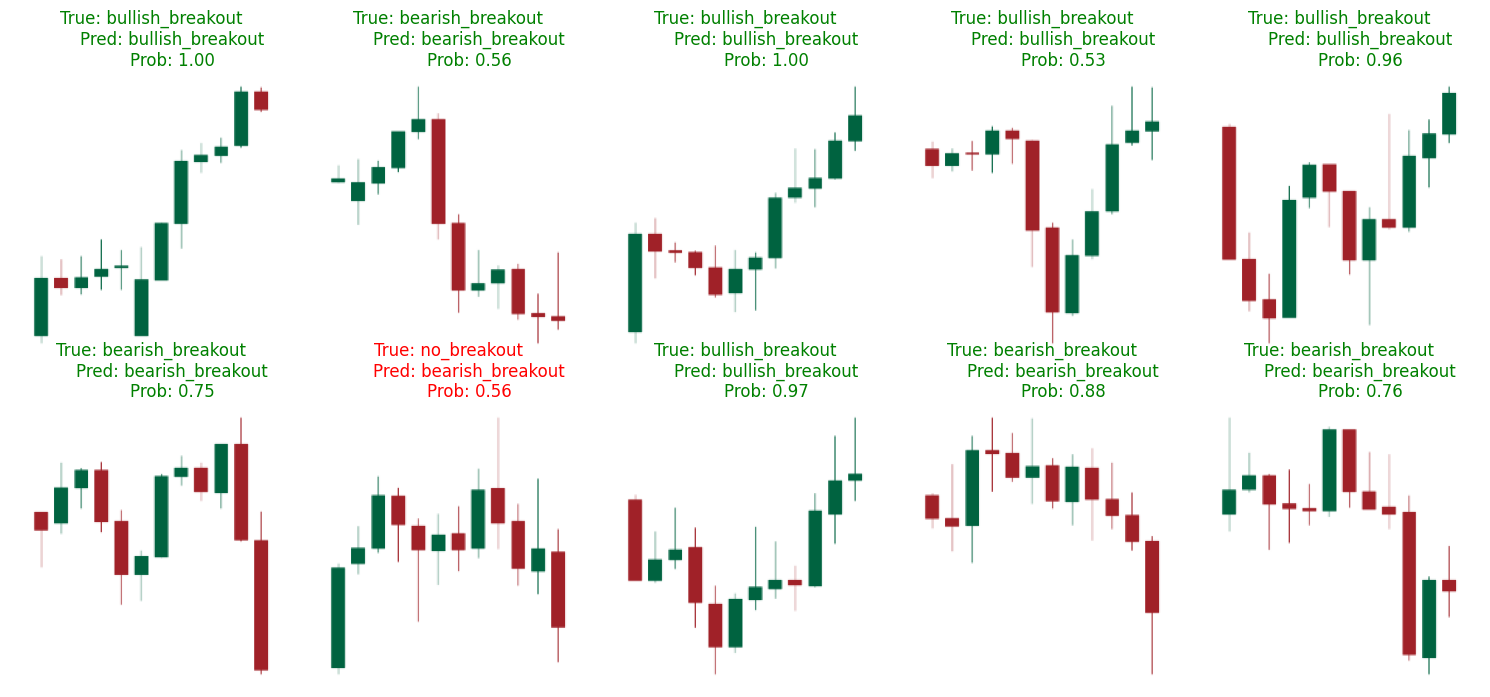

In [ ]:
# Choose random indexes from the test data and compare the values for specific predictions
import random

# Filter indexes for specific predictions ('bullish_breakout' and 'bearish_breakout')
filtered_indexes = [
    i for i, probs in enumerate(test_preds)
    if class_names[tf.argmax(probs)] in ["bullish_breakout", "bearish_breakout"]
]

# If there are fewer than 10 examples, adjust the number of samples
num_samples = min(10, len(filtered_indexes))

# Select random indexes from the filtered list
random_indexes = random.sample(filtered_indexes, num_samples)

# Create a plot with multiple subplots (adjust layout for fewer images if necessary)
cols = 5
rows = (num_samples + cols - 1) // cols  # Calculate required rows
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))

# Flatten axes array for easier indexing (in case of fewer images)
axes = axes.flatten()

# Loop through the filtered indexes and plot
for i, ax in enumerate(axes):
    if i < num_samples:
        target_index = random_indexes[i]

        # Get relevant target image, label, prediction, and prediction probabilities
        test_image = test_ds_images[target_index]
        test_image_truth_label = class_names[tf.argmax(test_ds_labels[target_index])]
        test_image_pred_probs = test_preds[target_index]
        test_image_pred_class = class_names[tf.argmax(test_image_pred_probs)]

        # Plot the image
        ax.imshow(test_image.astype("uint8"))

        # Create sample title
        title = f"""True: {test_image_truth_label}
        Pred: {test_image_pred_class}
        Prob: {np.max(test_image_pred_probs):.2f}"""

        # Color the title based on the correctness of the prediction
        ax.set_title(title,
                     color="green" if test_image_truth_label == test_image_pred_class else "red")
        ax.axis("off")
    else:
        ax.axis("off")  # Hide unused subplots

# Adjust layout
plt.tight_layout()
plt.show()


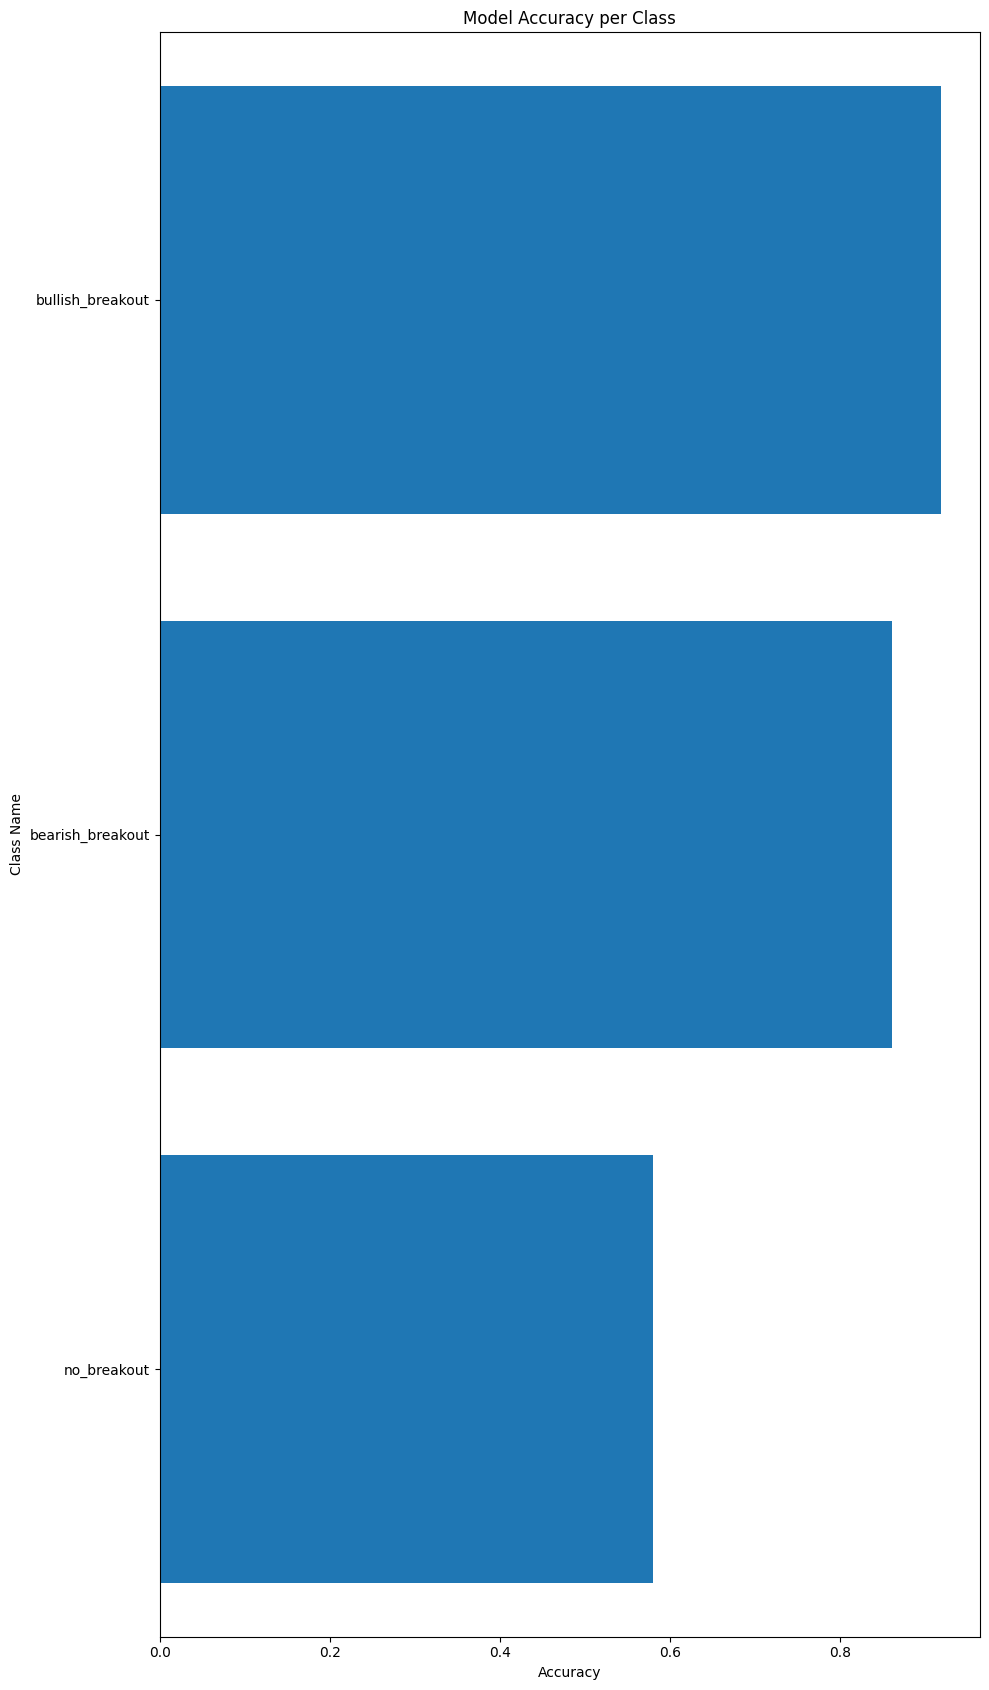

In [ ]:
# Get argmax labels of test predictions and test ground truth
test_preds_labels = test_preds.argmax(axis=-1)
test_ds_labels_argmax = test_ds_labels.argmax(axis=-1)

# Get highest prediction probability of test predictions
test_pred_probs_max = tf.reduce_max(test_preds, axis=-1).numpy()  # Convert Tensor to NumPy for pandas compatibility

# Create DataFrame of test results with file paths
test_results_df = pd.DataFrame({
    "file_path": file_paths,  # Use the extracted file paths
    "test_pred_label": test_preds_labels,
    "test_pred_prob": test_pred_probs_max,
    "test_pred_class_name": [class_names[test_pred_label] for test_pred_label in test_preds_labels],
    "test_truth_label": test_ds_labels_argmax,
    "test_truth_class_name": [class_names[test_truth_label] for test_truth_label in test_ds_labels_argmax]
})

# Create a column indicating whether the prediction matches the true label
test_results_df["correct"] = test_results_df["test_pred_class_name"] == test_results_df["test_truth_class_name"]

# Calculate accuracy per class
accuracy_per_class = test_results_df.groupby("test_truth_class_name")["correct"].mean()

# Create a new DataFrame to sort classes by accuracy
accuracy_per_class_df = pd.DataFrame(accuracy_per_class).reset_index().sort_values("correct", ascending=False)

# Create a horizontal bar chart to display accuracy per class
plt.figure(figsize=(10, 17))
plt.barh(y=accuracy_per_class_df["test_truth_class_name"],
         width=accuracy_per_class_df["correct"])
plt.xlabel("Accuracy")
plt.ylabel("Class Name")
plt.title("Model Accuracy per Class")
plt.ylim(-0.5, len(accuracy_per_class_df["test_truth_class_name"]) - 0.5)  # Adjust y-axis limits to reduce white space
plt.gca().invert_yaxis()  # This will display the first class at the top
plt.tight_layout()
plt.show()


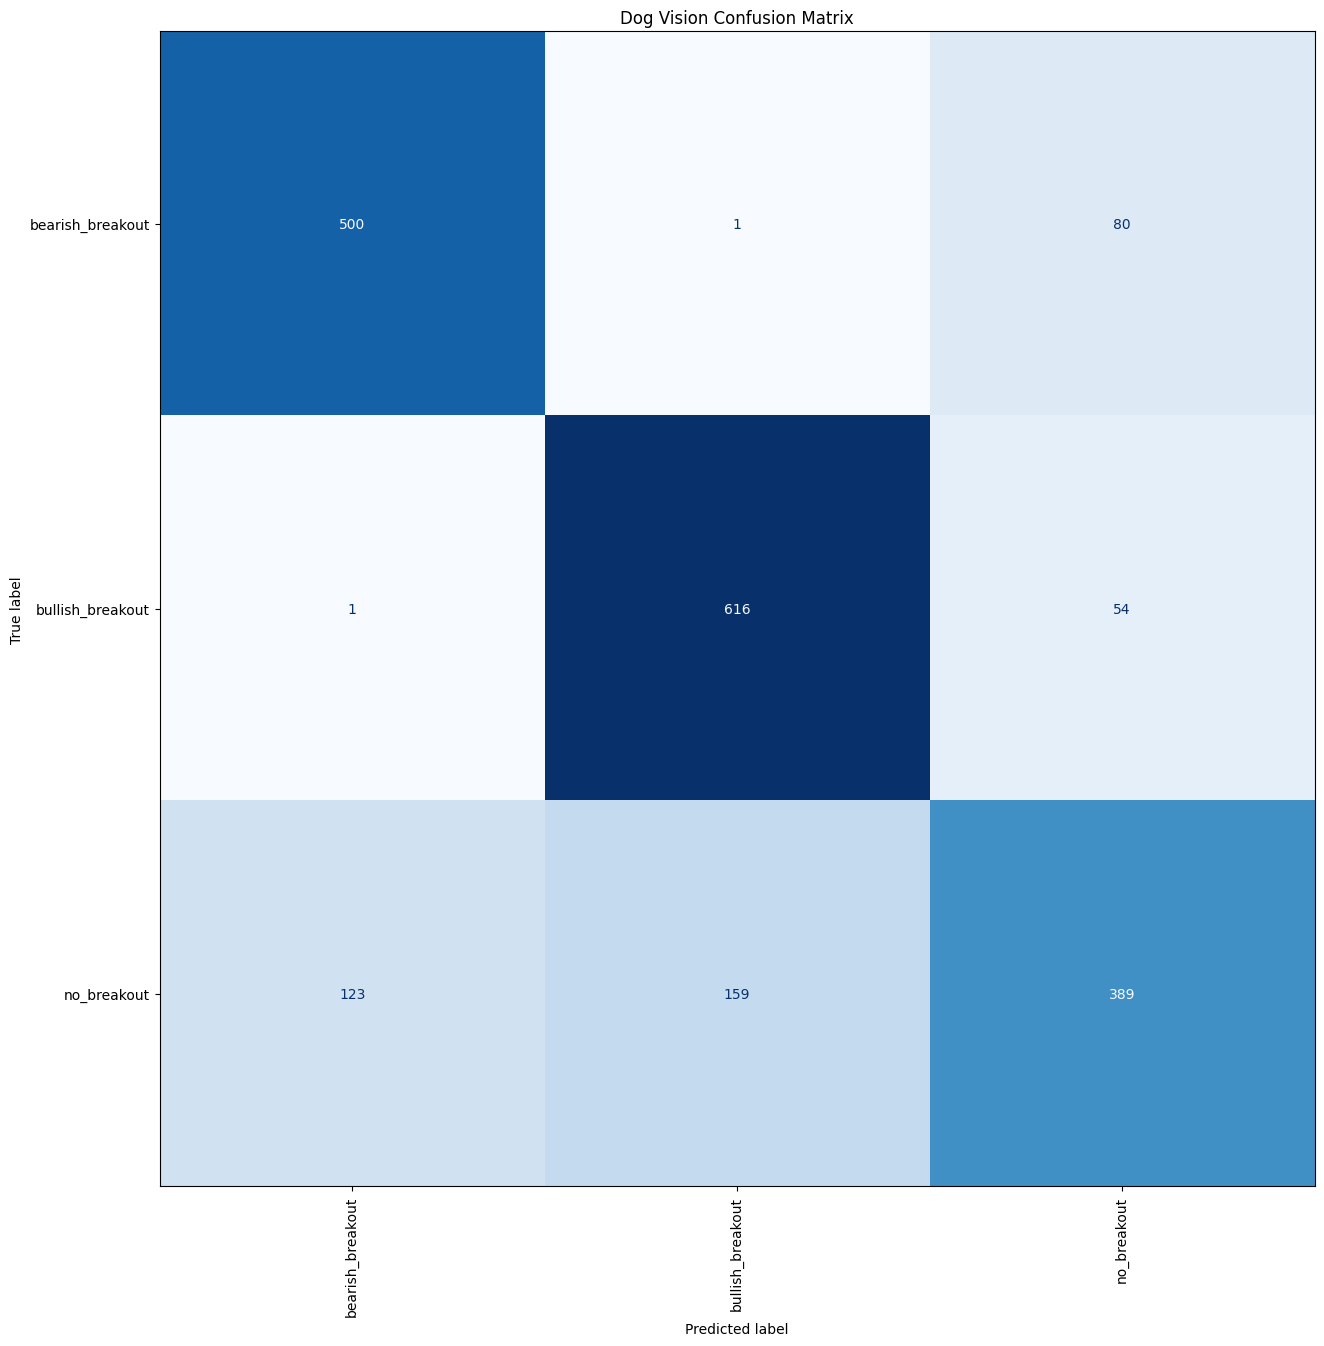

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
confusion_matrix_dog_preds = confusion_matrix(y_true=test_ds_labels_argmax, # requires all labels to be in same format (e.g. not one-hot)
                                              y_pred=test_preds_labels)
# Create a confusion matrix plot
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dog_preds,
                                                  display_labels=class_names)
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Dog Vision Confusion Matrix")
confusion_matrix_display.plot(xticks_rotation="vertical",
                              cmap="Blues",
                              colorbar=False,
                              ax=ax);

In [ ]:
# Create a confusion matrix
confusion_matrix_dog_preds = confusion_matrix(
    y_true=test_ds_labels_argmax,  # Ground truth labels
    y_pred=test_preds_labels       # Predicted labels
)

# Dynamically extract values from the confusion matrix
class_names = ["bearish_breakout", "bullish_breakout", "no_breakout"]
cm = confusion_matrix_dog_preds  # Alias for easier reference

# Generate text output dynamically for each class
output_text = ""
for i, class_name in enumerate(class_names):
    output_text += f"True '{class_name}':\n"
    for j, predicted_class in enumerate(class_names):
        output_text += f"  Predicted as '{predicted_class}': {cm[i, j]} times.\n"
    output_text += "\n"

# Print the dynamically generated text
print(output_text)

True 'bearish_breakout':
  Predicted as 'bearish_breakout': 500 times.
  Predicted as 'bullish_breakout': 1 times.
  Predicted as 'no_breakout': 80 times.

True 'bullish_breakout':
  Predicted as 'bearish_breakout': 1 times.
  Predicted as 'bullish_breakout': 616 times.
  Predicted as 'no_breakout': 54 times.

True 'no_breakout':
  Predicted as 'bearish_breakout': 123 times.
  Predicted as 'bullish_breakout': 159 times.
  Predicted as 'no_breakout': 389 times.




In [ ]:
# Define the target classes for evaluation
target_classes = ["bullish_breakout", "bearish_breakout"]

# Get the true labels as class names
true_labels = [class_names[tf.argmax(label)] for label in test_ds_labels]

# Get the predicted labels as class names
predicted_labels = [class_names[tf.argmax(pred)] for pred in test_preds]

# Calculate the number of true labels for each class
true_bullish_count = sum(label == "bullish_breakout" for label in true_labels)
true_bearish_count = sum(label == "bearish_breakout" for label in true_labels)
true_no_breakout_count = sum(label == "no_breakout" for label in true_labels)

# Total number of true 'bullish_breakout' and 'bearish_breakout' labels
total_bullish_bearish_labels = true_bullish_count + true_bearish_count

# Correct predictions for 'bullish_breakout' and 'bearish_breakout'
correct_bullish = sum(
    true_labels[i] == "bullish_breakout" and predicted_labels[i] == "bullish_breakout"
    for i in range(len(true_labels))
)
correct_bearish = sum(
    true_labels[i] == "bearish_breakout" and predicted_labels[i] == "bearish_breakout"
    for i in range(len(true_labels))
)

# Incorrect predictions: predicted 'no_breakout' but the true label is 'bullish_breakout' or 'bearish_breakout'
incorrect_to_no_breakout = sum(
    true_labels[i] in target_classes and predicted_labels[i] == "no_breakout"
    for i in range(len(true_labels))
)

# Incorrect predictions: predicted 'bullish_breakout' or 'bearish_breakout' but true label is 'no_breakout'
incorrect_bullish = sum(
    true_labels[i] == "no_breakout" and predicted_labels[i] == "bullish_breakout"
    for i in range(len(true_labels))
)
incorrect_bearish = sum(
    true_labels[i] == "no_breakout" and predicted_labels[i] == "bearish_breakout"
    for i in range(len(true_labels))
)

# Total correct and incorrect predictions
total_correct = correct_bullish + correct_bearish
total_incorrect_to_no_breakout = incorrect_to_no_breakout
total_incorrect_from_no_breakout = incorrect_bullish + incorrect_bearish

# Calculate percentages
correct_bullish_percentage = (correct_bullish / true_bullish_count) * 100 if total_bullish_bearish_labels > 0 else 0
correct_bearish_percentage = (correct_bearish / true_bearish_count) * 100 if total_bullish_bearish_labels > 0 else 0
incorrect_to_no_breakout_percentage = (total_incorrect_to_no_breakout / total_bullish_bearish_labels) * 100 if total_bullish_bearish_labels > 0 else 0
incorrect_bullish_percentage = (incorrect_bullish / true_no_breakout_count) * 100 if true_no_breakout_count > 0 else 0
incorrect_bearish_percentage = (incorrect_bearish / true_no_breakout_count) * 100 if true_no_breakout_count > 0 else 0
total_correct_percentage = (total_correct / total_bullish_bearish_labels) * 100 if total_bullish_bearish_labels > 0 else 0
total_incorrect_percentage = (total_incorrect_from_no_breakout / true_no_breakout_count) * 100 if true_no_breakout_count > 0 else 0

# Print the results in comparison
print("Comparison of correct and incorrect predictions:")
print(f"Correct 'bullish_breakout': Predicted as 'bullish_breakout' {correct_bullish} times "
      f"({correct_bullish_percentage:.2f}%).")
print(f"Correct 'bearish_breakout': Predicted as 'bearish_breakout' {correct_bearish} times "
      f"({correct_bearish_percentage:.2f}%).")
print(f"Incorrect 'bullish_breakout': Predicted as 'bullish_breakout' but true label was 'no_breakout' {incorrect_bullish} times "
      f"({incorrect_bullish_percentage:.2f}%).")
print(f"Incorrect 'bearish_breakout': Predicted as 'bearish_breakout' but true label was 'no_breakout' {incorrect_bearish} times "
      f"({incorrect_bearish_percentage:.2f}%).")

# Overall comparison
print(f"\nTotal correct predictions (True 'bullish_breakout' or 'bearish_breakout'): {total_correct} "
      f"({total_correct_percentage:.2f}%).")
print(f"Total incorrect predictions to 'no_breakout' (Predicted as 'no_breakout' but True 'bullish_breakout' or 'bearish_breakout'): {total_incorrect_to_no_breakout} "
      f"({incorrect_to_no_breakout_percentage:.2f}%).")
print(f"Total incorrect predictions from 'no_breakout' (Predicted 'bullish_breakout' or 'bearish_breakout' but True 'no_breakout'): {total_incorrect_from_no_breakout} "
      f"({total_incorrect_percentage:.2f}%).")


Comparison of correct and incorrect predictions:
Correct 'bullish_breakout': Predicted as 'bullish_breakout' 616 times (91.80%).
Correct 'bearish_breakout': Predicted as 'bearish_breakout' 500 times (86.06%).
Incorrect 'bullish_breakout': Predicted as 'bullish_breakout' but true label was 'no_breakout' 159 times (23.70%).
Incorrect 'bearish_breakout': Predicted as 'bearish_breakout' but true label was 'no_breakout' 123 times (18.33%).

Total correct predictions (True 'bullish_breakout' or 'bearish_breakout'): 1116 (89.14%).
Total incorrect predictions to 'no_breakout' (Predicted as 'no_breakout' but True 'bullish_breakout' or 'bearish_breakout'): 134 (10.70%).
Total incorrect predictions from 'no_breakout' (Predicted 'bullish_breakout' or 'bearish_breakout' but True 'no_breakout'): 282 (42.03%).


In [ ]:
def get_random_sample_by_predicted_class(test_results_df, predicted_class, num_samples=1):
    """
    Get random file paths from the test dataset where the model predicted a specific class.

    Args:
        test_results_df (pd.DataFrame): DataFrame containing test results, including file paths and predictions.
        predicted_class (str): The class name to filter (e.g., 'bullish_breakout', 'bearish_breakout', 'no_breakout').
        num_samples (int): Number of random samples to retrieve (default is 1).

    Returns:
        list: A list of file paths matching the predicted class.
    """
    # Filter the DataFrame for the specified predicted class
    filtered_df = test_results_df[test_results_df["test_pred_class_name"] == predicted_class]

    # Check if there are enough samples to choose from
    if filtered_df.empty:
        print(f"No samples found for the predicted class: {predicted_class}")
        return []

    # Randomly select specified number of samples
    sampled_df = filtered_df.sample(n=min(num_samples, len(filtered_df)), random_state=42)

    # Return file paths as a list
    return sampled_df["file_path"].tolist()

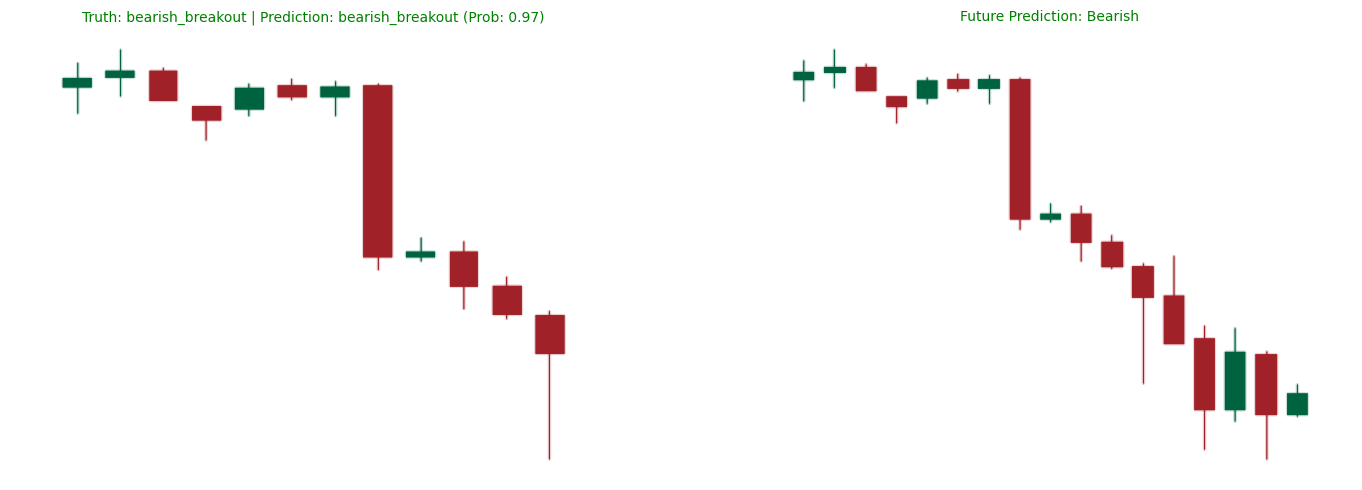

In [ ]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

def get_sample_details_and_display_with_future(test_results_df, predicted_class=None, num_samples=1, future_folder_path=""):
    """
    Get details of random samples where the model predicted a specific class and display them alongside future images.
    If no predicted_class is specified, a random class from ['bullish_breakout', 'bearish_breakout'] is chosen.

    Args:
        test_results_df (pd.DataFrame): DataFrame containing test results, including file paths and predictions.
        predicted_class (str): The class name to filter (e.g., 'bullish_breakout', 'bearish_breakout', 'no_breakout').
                               If None, a random class from ['bullish_breakout', 'bearish_breakout'] is selected.
        num_samples (int): Number of random samples to retrieve (default is 1).
        future_folder_path (str): Path to the folder containing future images.

    Returns:
        pd.DataFrame: A DataFrame containing details of the selected samples.
    """
    # Define the list of classes to choose from if predicted_class is not provided
    possible_classes = ['bullish_breakout', 'bearish_breakout', 'no_breakout']

    # Randomly select a class if predicted_class is not provided
    if not predicted_class:
        predicted_class = random.choice(possible_classes)
        print(f"No predicted_class specified. Randomly selected: {predicted_class}")

    # Filter the DataFrame for the specified predicted class
    filtered_df = test_results_df[test_results_df["test_pred_class_name"] == predicted_class]

    # Check if there are enough samples to choose from
    if filtered_df.empty:
        print(f"No samples found for the predicted class: {predicted_class}")
        return pd.DataFrame()

    valid_samples = []
    remaining_samples = filtered_df.copy()

    # Dynamically find samples with valid future matches
    while len(valid_samples) < num_samples and not remaining_samples.empty:
        # Randomly sample one row
        row = remaining_samples.sample(n=1).iloc[0]
        base_file_name = os.path.basename(row["file_path"])

        # Search the future folder for a matching file (ignoring "future_" prefix)
        future_file_path = None
        future_folder_keyword = None
        for root, dirs, files in os.walk(future_folder_path):
            for file in files:
                # Remove "future_" prefix for comparison
                stripped_file_name = file.replace("future_", "")
                if stripped_file_name == base_file_name:
                    future_file_path = os.path.join(root, file)
                    # Extract keyword from folder name
                    future_folder_keyword = next((kw for kw in ["bullish", "bearish", "no breakout"] if kw in root.lower()), None)
                    break
            if future_file_path:
                break

        # If a matching future file is found, add to valid samples
        if future_file_path:
            valid_samples.append((row, future_file_path, future_folder_keyword))
        else:
            # Remove the invalid sample from consideration
            remaining_samples = remaining_samples.drop(index=row.name)

    # Display details for each valid sample
    if not valid_samples:
        print("No valid samples with matching future files found.")
        return pd.DataFrame()

    plt.figure(figsize=(15, len(valid_samples) * 5))  # Dynamically adjust figure size
    for i, (row, future_file_path, future_folder_keyword) in enumerate(valid_samples):
        current_image = mpimg.imread(row["file_path"])
        future_image = mpimg.imread(future_file_path)

        # Plot current image
        ax1 = plt.subplot(len(valid_samples), 2, i * 2 + 1)
        ax1.imshow(current_image)
        ax1.axis("off")
        current_title_color = "green" if row["correct"] else "red"
        ax1.set_title(
            f"Truth: {row['test_truth_class_name']} | Prediction: {row['test_pred_class_name']} (Prob: {row['test_pred_prob']:.2f})",
            color=current_title_color,
            fontsize=10,
        )

        # Plot future image
        ax2 = plt.subplot(len(valid_samples), 2, i * 2 + 2)
        ax2.imshow(future_image)
        ax2.axis("off")

        # Determine the future title color, treating None as "no breakout"
        if future_folder_keyword in [None, "no breakout"]:
            future_title_color = "green" if row["test_pred_class_name"] == "no_breakout" else "red"
        else:
            future_title_color = "green" if (
                (future_folder_keyword == "bullish" and row["test_pred_class_name"] == "bullish_breakout")
                or (future_folder_keyword == "bearish" and row["test_pred_class_name"] == "bearish_breakout")
            ) else "red"

        # Set the title for the future image
        ax2.set_title(
            f"Future Prediction: {future_folder_keyword.capitalize() if future_folder_keyword else 'No Breakout'}",
            color=future_title_color,
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

    # Return the DataFrame of valid samples for reference
    valid_samples_df = pd.DataFrame([row for row, _, _ in valid_samples])
    return valid_samples_df

# Example Usage:
# Assuming 'test_results_df' contains the test results and 'file_paths' contains the image file paths
future_folder_path = "/content/output_latest.zip/output_1_hour/output_future/output_hourly_price_action_patterns_testing/test"
sampled_details = get_sample_details_and_display_with_future(
    test_results_df, predicted_class="bearish_breakout", num_samples=1, future_folder_path=future_folder_path
)


In [ ]:
import os

def get_unique_currency_pairs(folder_path):
    """
    Extract unique currency pairs from the file names in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the files.

    Returns:
        list: A list of unique currency pairs (e.g., 'AUDCAD', 'AUDCHF').
    """
    # Set to store unique currency pairs
    unique_currency_pairs = set()

    # Traverse the folder and get file names
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"):  # Ensure only image files are processed
                # Extract the currency pair (first part before '_')
                currency_pair = file.split("_")[0]
                unique_currency_pairs.add(currency_pair)

    # Convert the set to a sorted list
    return sorted(unique_currency_pairs)


# Specify the folder path
folder_path = "/content/output_latest.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_training_and_validation/train/bullish_breakout"

# Get the list of unique currency pairs
unique_pairs = get_unique_currency_pairs(folder_path)

# Print the unique currency pairs
print("Unique Currency Pairs:", unique_pairs)

Unique Currency Pairs: []
